# Autoencoders para reducción de dimensionalidad de las señales

* Dado que PCA no es un modelo que soporte autodiferenciación, no es posible entrenar un modelo full pipeline completo con esto en medio, por lo tanto es necesario explorar la posibiblidad de utilizar autoencoders para reducir la dimensionalidad de las señales. Sabemos que con 3 dimensiones ya tenemos un buen resultado, por lo tanto vamos a intentar reducir la dimensionalidad de las señales a 3 dimensiones utilizando autoencoders.

In [1]:
using CSV
using DataFrames
using Flux
using Plots
using Random
using IterTools: ncycle
using ProgressMeter
include("../1-GeneracionDatos/Parameters.jl")
rng = Random.seed!(1234);

In [2]:
path_signals = "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/1-GeneracionDatos/Data/SignalHahn_TE_1_G_8.73e-7_forPCA.csv"
signalsDF = CSV.read(path_signals, DataFrame);

In [3]:
column_lcm = collect(lcms)
column_sigma = collect(σs)

pdistparamsDF = zeros(size(signalsDF)[2], 2)

for (i, lcm) in enumerate(column_lcm)
    for (j, sigma) in enumerate(column_sigma)
        pdistparamsDF[(i - 1) * length(σs) + j, 1] = sigma
        pdistparamsDF[(i - 1) * length(σs) + j, 2] = lcm
    end
end

pdistparamsDF = DataFrame(pdistparamsDF, [:sigma, :lcm]);

In [4]:
perm = shuffle(rng, 1:55100);

In [5]:
# Random Shuflle the data
signalsDF = signalsDF[:, perm]
pdistparamsDF = pdistparamsDF[perm, :];

In [6]:
# Split the data in training, validation and test
n_signals = size(signalsDF, 2)
n_train = Int(floor(n_signals*0.7))
n_val = Int(floor(n_signals*0.15))
n_test = n_signals - n_train - n_val


train_signals = Float32.(Matrix(signalsDF[:, 1:n_train]))
val_signals = Float32.(Matrix(signalsDF[:, n_train+1:n_train+n_val]))
test_signals = Float32.(Matrix(signalsDF[:, n_train+n_val+1:end]))

train_params = pdistparamsDF[1:n_train, :]
val_params = pdistparamsDF[n_train+1:n_train+n_val, :]
test_params = pdistparamsDF[n_train+n_val+1:end, :];

In [7]:
n_times = size(train_signals, 1)

1100

In [8]:
encoder = Chain(Dense(n_times, 500, identity),
                  Dense(500, 100, identity),
                  Dense(100, 50, identity),
                  Dense(50, 3, identity))

decoder = Chain(Dense(3, 50, identity),
                Dense(50, 100, identity),
                Dense(100, 500, identity),
                Dense(500, n_times, identity))

autoencoder = Chain(encoder, decoder)

Chain(
  Chain(
    Dense(1100 => 500),                 # 550_500 parameters
    Dense(500 => 100),                  # 50_100 parameters
    Dense(100 => 50),                   # 5_050 parameters
    Dense(50 => 3),                     # 153 parameters
  ),
  Chain(
    Dense(3 => 50),                     # 200 parameters
    Dense(50 => 100),                   # 5_100 parameters
    Dense(100 => 500),                  # 50_500 parameters
    Dense(500 => 1100),                 # 551_100 parameters
  ),
)                   # Total: 16 arrays, 1_212_703 parameters, 4.627 MiB.

In [9]:
a_params, a_re = Flux.destructure(autoencoder)

(Float32[-0.024023626, -0.033861384, -0.030936167, 0.05846425, 0.019941935, 0.047768522, -0.0031517083, -0.002898966, 0.05469548, -0.021101657  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Restructure(Chain, ..., 1212703))

In [10]:
loader = Flux.DataLoader((train_signals, train_signals), batchsize=100, shuffle=false)

386-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, batchsize=100)
  with first element:
  (1100×100 Matrix{Float32}, 1100×100 Matrix{Float32},)

In [11]:
optim = Flux.setup(Flux.AdamW(0.01), autoencoder)

(layers = ((layers = ((weight = Leaf(OptimiserChain(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), WeightDecay{Int64}(0)), ((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999)), nothing)), bias = Leaf(OptimiserChain(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), WeightDecay{Int64}(0)), ((Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999)), nothing)), σ = ()), (weight = Leaf(OptimiserChain(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), WeightDecay{Int64}(0)), ((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999)), nothing)), bias = Leaf(Optim

In [12]:
function loss_reconstruction(x, y)
    return Flux.mse(a_re(a_params)(x), y)
end

loss_reconstruction (generic function with 1 method)

In [13]:
losses = []
losses_val = []
@showprogress for epoch in 1:25
    for (x, y) in loader
        loss, grads = Flux.withgradient(autoencoder) do m
            Flux.mse(m(x), y)
        end
        Flux.update!(optim, autoencoder, grads[1])
    end
    actual_loss = Flux.mse(autoencoder(train_signals), train_signals)
    actual_val_loss = Flux.mse(autoencoder(val_signals), val_signals)
    push!(losses, actual_loss)
    push!(losses_val, actual_val_loss)
    println("Epoch: $epoch | Loss: $actual_loss | Loss Val: $actual_val_loss")
    GC.gc()
end

Epoch: 1 | Loss: 0.008376783 | Loss Val: 0.008371072
Epoch: 2 | Loss: 0.001662159 | Loss Val: 0.0016923388

Progress:   8%|████                                     |  ETA: 0:04:41


Epoch: 3 | Loss: 0.0013895817 | Loss Val: 0.0014213029


Progress:  12%|█████                                    |  ETA: 0:03:51

Epoch: 4 | Loss: 0.0013343722 | Loss Val: 0.0013651056


Progress:  16%|███████                                  |  ETA: 0:03:20

Epoch: 5 | Loss: 0.0012959702 | Loss Val: 0.0013259415


Progress:  20%|█████████                                |  ETA: 0:02:59

Epoch: 6 | Loss: 0.0012653685 | Loss Val: 0.0012946052


Progress:  24%|██████████                               |  ETA: 0:02:42

Epoch: 7 | Loss: 0.001264941 | Loss Val: 0.0012928069


Progress:  28%|████████████                             |  ETA: 0:02:28

Epoch: 8 | Loss: 0.001213333 | Loss Val: 0.0012405443

Progress:  32%|██████████████                           |  ETA: 0:02:17


Epoch: 9 | Loss: 0.0011441831 | Loss Val: 0.0011696464

Progress:  36%|███████████████                          |  ETA: 0:02:06


Epoch: 10 | Loss: 0.0010165931 | Loss Val: 0.0010384679


Progress:  40%|█████████████████                        |  ETA: 0:01:56

Epoch: 11 | Loss: 0.00073829707 | Loss Val: 0.0007519395

Progress:  44%|███████████████████                      |  ETA: 0:01:47


Epoch: 12 | Loss: 0.0003662348 | Loss Val: 0.00036807318


Progress:  48%|████████████████████                     |  ETA: 0:01:38

Epoch: 13 | Loss: 0.00022209971 | Loss Val: 0.00021937717


Progress:  52%|██████████████████████                   |  ETA: 0:01:30

Epoch: 14 | Loss: 0.00018754209 | Loss Val: 0.00018391368


Progress:  56%|███████████████████████                  |  ETA: 0:01:22

Epoch: 15 | Loss: 0.00017494604 | Loss Val: 0.0001711801


Progress:  60%|█████████████████████████                |  ETA: 0:01:14

Epoch: 16 | Loss: 0.00016268947 | Loss Val: 0.00015910785


Progress:  64%|███████████████████████████              |  ETA: 0:01:06

Epoch: 17 | Loss: 0.0001442385 | Loss Val: 0.00014106899


Progress:  72%|██████████████████████████████           |  ETA: 0:00:51

Epoch: 18 | Loss: 0.00011601814 | Loss Val: 0.0001135097
Epoch: 19 | Loss: 8.4200685e-5 | Loss Val: 8.240519e-5

Progress:  76%|████████████████████████████████         |  ETA: 0:00:43


Epoch: 20 | Loss: 6.0288497e-5 | Loss Val: 5.901934e-5

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:36


Epoch: 21 | Loss: 7.554489e-5 | Loss Val: 7.466133e-5

Progress:  84%|███████████████████████████████████      |  ETA: 0:00:29


Epoch: 22 | Loss: 4.8185993e-5 | Loss Val: 4.7215788e-5


Progress:  88%|█████████████████████████████████████    |  ETA: 0:00:21

Epoch: 23 | Loss: 6.093289e-5 | Loss Val: 6.016339e-5


Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:14

Epoch: 24 | Loss: 3.957883e9 | Loss Val: 3.9496778e9


Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:07

Epoch: 25 | Loss: 1.1557703e7 | Loss Val: 1.1884348e7


Progress: 100%|█████████████████████████████████████████| Time: 0:02:55


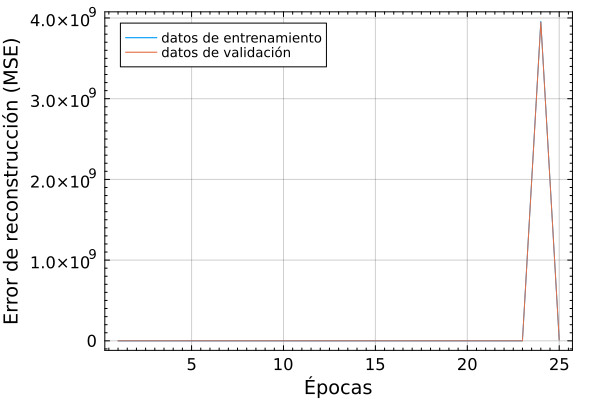

In [14]:
using Measures
plot(losses, label="datos de entrenamiento", legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
plot!(losses_val, label = "datos de validación")
xlabel!("Épocas")
ylabel!("Error de reconstrucción (MSE)")

In [15]:
encoder_params, encoder_re = Flux.destructure(encoder)
decoder_params, decoder_re = Flux.destructure(decoder)

(Float32[0.33255166, -0.0014320477, -0.17412168, -0.2209154, -0.085706726, 0.29826322, -0.3700859, -0.16540837, -0.061310295, 0.18958203  …  0.58233917, 0.42257294, -0.5567234, -0.61979145, -0.570177, -0.5961097, -0.5779401, 0.6246008, 0.6387835, -0.61539775], Restructure(Chain, ..., 606900))

In [24]:
df_encoder = DataFrame(reshape(encoder_params, length(encoder_params), 1), :auto)
df_decoder = DataFrame(reshape(decoder_params, length(decoder_params), 1), :auto)

CSV.write("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-2-Autoencoders/Models/ParamsE.csv", df_encoder)
CSV.write("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-2-Autoencoders/Models/ParamsD.csv", df_decoder)

"C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/2-2-Autoencoders/Models/ParamsD.csv"